# Tweet emotions detection using LSTM and DNN

## Installing required libraries

In [ ]:
!pip install pandas matplotlib tensorflow numpy wordcloud

## Importing required libraries

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization, LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
import tensorflow as tf
import numpy as np
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

## Data exploration

In [3]:
MAX_WORDS = 250000

In [4]:
DataSet = pd.read_csv("tweet_emotions.csv")
DataSet.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [5]:
DataSet.shape

(40000, 3)

In [6]:
print("number of classes: "+str(len(DataSet["sentiment"].unique())))
DataSet["sentiment"].unique()

number of classes: 13


array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [7]:
DataSet["sentiment"].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Bar plot of the number of occurences of each sentiment')

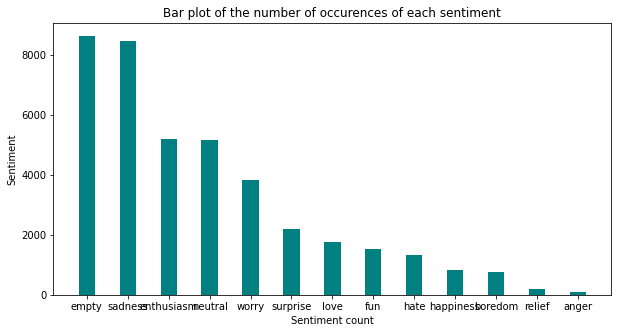

In [8]:
classCounts = np.array(DataSet["sentiment"].value_counts())
classNames = np.array(DataSet["sentiment"].unique())

fig = plt.figure(figsize = (10, 5))
plt.bar(classNames, classCounts, color ='teal',
        width = 0.4)

plt.xlabel("Sentiment count")
plt.ylabel("Sentiment")
plt.title("Bar plot of the number of occurences of each sentiment")

In [9]:
SadnessText = list(DataSet[DataSet["sentiment"]=="sadness"]["content"])
SadnessText = " ".join(SadnessText)
happinessText = list(DataSet[DataSet["sentiment"]=="happiness"]["content"])
happinessText = " ".join(happinessText)

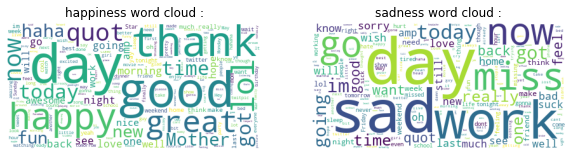

In [10]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(happinessText)
word_cloud.to_image
plt.imshow(word_cloud)
plt.axis("off")
plt.title("happiness word cloud :")

plt.subplot(222)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(SadnessText)
word_cloud.to_image
plt.imshow(word_cloud)
plt.axis("off")
plt.title("sadness word cloud :")

plt.show()

## Preparing the data for training

In [11]:
X = DataSet["content"]
X.head()

0    @tiffanylue i know  i was listenin to bad habi...
1    Layin n bed with a headache  ughhhh...waitin o...
2                  Funeral ceremony...gloomy friday...
3                 wants to hang out with friends SOON!
4    @dannycastillo We want to trade with someone w...
Name: content, dtype: object

In [12]:
y = DataSet["sentiment"]
y = pd.get_dummies(y, columns=[0], prefix='', prefix_sep='')
y.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
anger,40000.0,0.002750,0.052369,0.0,0.0,0.0,0.0,1.0
boredom,40000.0,0.004475,0.066746,0.0,0.0,0.0,0.0,1.0
empty,40000.0,0.020675,0.142296,0.0,0.0,0.0,0.0,1.0
enthusiasm,40000.0,0.018975,0.136438,0.0,0.0,0.0,0.0,1.0
fun,40000.0,0.044400,0.205985,0.0,0.0,0.0,0.0,1.0
happiness,40000.0,0.130225,0.336555,0.0,0.0,0.0,0.0,1.0
hate,40000.0,0.033075,0.178835,0.0,0.0,0.0,0.0,1.0
love,40000.0,0.096050,0.294663,0.0,0.0,0.0,0.0,1.0
neutral,40000.0,0.215950,0.411485,0.0,0.0,0.0,0.0,1.0
relief,40000.0,0.038150,0.191561,0.0,0.0,0.0,0.0,1.0


In [13]:
y.head()

,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0


## Modeling

### Preparing the text vectorisation layer

In [14]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=2000,
                               output_mode='int')

In [15]:
vectorizer.adapt(X.values)

In [16]:
vectorized_text = vectorizer("I just bought my first car!!!")
np.array(vectorized_text)

array([  2,  21, 556, ...,   0,   0,   0])

### Preparing the training, testing and validation pipeline

In [17]:
#Preparing Training, testing and validation pipeline:
vectorized_text = vectorizer(X.values)
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(40000)
dataset = dataset.batch(24)
dataset = dataset.prefetch(12)

In [18]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### Creating and training the model 

In [19]:
model = Sequential([
    Embedding(MAX_WORDS+1, 32),
    Bidirectional(LSTM(32, activation='tanh')),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(len(y.columns), activation='sigmoid')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics = ['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          8000032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 13)                1313      
                                                                 
Total params: 8,034,585
Trainable params: 8,034,585
Non-trainable params: 0
______________________________________________

In [20]:
history = model.fit(train, epochs=48, validation_data=val)

Epoch 1/48
1166/1166 [==============================] - 146s 115ms/step - loss: 2.0229 - categorical_accuracy: 0.2966 - val_loss: 1.8320 - val_categorical_accuracy: 0.3830
Epoch 2/48
1166/1166 [==============================] - 127s 109ms/step - loss: 1.7832 - categorical_accuracy: 0.3952 - val_loss: 1.5390 - val_categorical_accuracy: 0.4755
Epoch 3/48
1166/1166 [==============================] - 127s 109ms/step - loss: 1.5012 - categorical_accuracy: 0.4985 - val_loss: 1.1769 - val_categorical_accuracy: 0.6219
Epoch 4/48
1166/1166 [==============================] - 127s 109ms/step - loss: 1.1725 - categorical_accuracy: 0.6210 - val_loss: 0.9038 - val_categorical_accuracy: 0.7172
Epoch 5/48
1166/1166 [==============================] - 127s 108ms/step - loss: 0.9421 - categorical_accuracy: 0.7004 - val_loss: 0.7395 - val_categorical_accuracy: 0.7750
Epoch 6/48
1166/1166 [==============================] - 126s 108ms/step - loss: 0.7614 - categorical_accuracy: 0.7625 - val_loss: 0.5857 - v

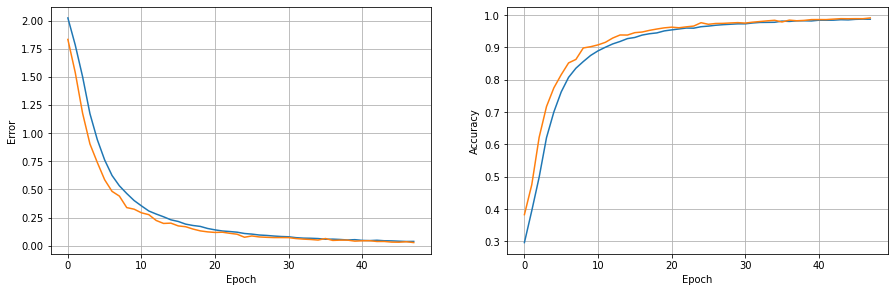

In [24]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.grid(True)

def plot_acc(history):
    plt.plot(history.history['categorical_accuracy'], label='accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

plt.figure(figsize=(15, 10))

plt.subplot(221)
plot_loss(history)

plt.subplot(222)
plot_acc(history)

# plt.show()

### Saving the model and making predictions

In [ ]:
# Saving the model
model.save("EmotionsModel")
model.save("EmotionsModel.h5")

In [26]:
LoadedModel = tf.keras.models.load_model('EmotionsModel.h5')

In [27]:
precision = tf.keras.metrics.Precision()
accuracy = tf.keras.metrics.CategoricalAccuracy()

In [28]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_test, y_test = batch
    # Make a prediction 
    y_pred = LoadedModel.predict(X_test)
    
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()
    
    precision.update_state(y_test, y_pred)
    accuracy.update_state(y_test, y_pred)

In [29]:
print(f'Precision: {precision.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision: 0.592553973197937, Accuracy:0.5903614163398743


In [44]:
input_text = ['i have a job interview today wish me luck', 'today is my birthday', 'finally, i graduated from highschool']
vecorized_text = vectorizer(input_text)
print("----------------------------------------")
for i in range(len(input_text)):
    res = LoadedModel.predict(np.expand_dims(vecorized_text.numpy()[i], 0))
    print('Text: '+input_text[i]+"\nPrediction: "+str(y.columns[np.array(tf.argmax(res, 1))][0]))
    print("----------------------------------------")

----------------------------------------
Text: i have a job interview today wish me luck
Prediction: worry
----------------------------------------
Text: today is my birthday
Prediction: neutral
----------------------------------------
Text: finally, i graduated from highschool
Prediction: happiness
----------------------------------------
